In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)
data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

data_all.shape

In [41]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features
import pandas as pd
import pickle
import os
import numpy as np
from copy import deepcopy


def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>50:
        return [],[],[],[],[],[],[]
    index2 = np.isnan(ecg_rr)
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    weights = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         ppg_qual[index2] = -.1
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -.5
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[tmp[:,k]>0,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        weights.append(np.abs(tmp[:,0]-ecg_rr).reshape(1,60,1))
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals,weights

# unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    if len(np.where(df[:,-6]>=.6)[0])<5:
        return np.zeros((0,60,11))
    return df.reshape(-1,60,11)

def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return [],[],[],[],[],[],[]
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col


def get_df(f):
    data_all = pickle.load(open(f,'rb'))
    data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
    data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
    data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
    data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
    data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
    data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
    data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
    values = data_all[['ppg_rr','index']].values
    values = [a[b] for a,b in values]
    data_all['ppg_rr_best'] = values
    data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))
    return get_all_data(data_all)

directory = '../data_users1/ecg_ppg/'
all_X = Parallel(n_jobs=30,verbose=5)(delayed(get_df)(directory+f) for f in os.listdir(directory) if f[-1]=='p')
# all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:   13.4s
[Parallel(n_jobs=30)]: Done  98 out of 130 | elapsed:  1.9min remaining:   37.8s
[Parallel(n_jobs=30)]: Done 125 out of 130 | elapsed:  2.4min remaining:    5.8s
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:  2.5min finished


In [42]:
X,y,ecg,means,stds,quals,weights = [],[],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])
        weights.extend(a[6])

import pickle
pickle.dump([X,y,ecg,means,stds,quals,weights],open('../data_users1/processed_data_weights.p','wb'),protocol=4)

In [43]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals,weights = pickle.load(open('../data_users1/processed_data_weights.p','rb'))

X,y,ecg,means,stds,quals,weights = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals).reshape(-1,60),np.concatenate(weights).reshape(-1,60)

# quals.shape

# weights[weights>400] = 400
# weights = 1- weights/400
# weights[weights<.2] = .2
# quals[quals<.2] = .2
# quals = quals+1

# np.unique(quals.reshape(-1))

# weights.shape,y.shape
from copy import deepcopy
r = deepcopy(quals)
r[r<.1] = .1
# r = r+.5
y = np.concatenate([y.reshape(-1,60,1),r.reshape(-1,60,1)],axis=2)
y.shape

(177844, 60, 2)

In [44]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test1,ecg_train, \
ecg_test,weights_train,weights_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,4,5,6])], y,ecg,weights,quals, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val,weights_train,weights_val = train_test_split(
    X_train, y_train,weights_train, test_size=0.2, random_state=4)
print(X_train.shape,y_train.shape,y_test1.shape,y_val.shape,weights_val.shape)

(113820, 60, 6) (113820, 60, 2) (35569, 60, 2) (28455, 60, 2) (28455, 60)


In [45]:
def meanabserror(y_true,y_pred):
    diff = K.abs((y_true - y_pred))
    return K.mean(diff, axis=-1)

def custom_mae(y_true,y_pred):
    weights = y_true[:,:,1]
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.abs((y_true - y_pred)
                 / K.clip(K.abs(y_true),K.epsilon(),None))
    diff = diff*weights
    return .4*K.mean(diff, axis=-1) +  .6*losses.mean_absolute_error(y_true,y_pred)
#     return losses.mean_absolute_error(y_true,y_pred)

timesteps = 60
input_dim = 6
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
encoded1 = Flatten()(inputs)
encoded1 = Dense(120,activation='relu')(encoded1)
encoded1 = Dense(60,activation='relu')(encoded1)
encoded1 = Dense(40,activation='relu')(encoded1)
encoded1 = Dense(30,activation='relu')(encoded1)


# inputs2 = Reshape((timesteps*input_dim,1))(inputs)
# encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
# att = Dense(1,activation='relu')(inputs2)

# att = Flatten()(inputs2)
# att = Activation(activation="softmax")(att)
# att = RepeatVector(120)(att)
# att = Permute((2,1))(att)
# mer = multiply([att, encoded])

# encoded = Flatten()(inputs)
encoded = Dense(30,activation='relu',name='sequence1')(encoded1)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
encoded = RepeatVector(2)(encoded)
encoded = Permute((2,1))(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
sequence_autoencoder.compile(optimizer='adam',loss=custom_mae)
sequence_autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 60, 6)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 360)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               43320     
_________________________________________________________________
dense_11 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_12 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_13 (Dense)             (None, 30)                1230      
_________________________________________________________________
sequence1 (Dense)            (None, 30)                930 

In [46]:
filepath = '../models/base_LSTM_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=300,
                batch_size=1000,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 113820 samples, validate on 28455 samples
Epoch 1/300
113820/113820 [==============================] - 2s 15us/step - loss: 287.0116 - val_loss: 267.9459

Epoch 00001: val_loss improved from inf to 267.94588, saving model to ../models/base_LSTM_weights.hdf5
Epoch 2/300
113820/113820 [==============================] - 2s 14us/step - loss: 267.7780 - val_loss: 267.4145

Epoch 00002: val_loss improved from 267.94588 to 267.41454, saving model to ../models/base_LSTM_weights.hdf5
Epoch 3/300
113820/113820 [==============================] - 2s 15us/step - loss: 267.4228 - val_loss: 267.1043

Epoch 00003: val_loss improved from 267.41454 to 267.10429, saving model to ../models/base_LSTM_weights.hdf5
Epoch 4/300
113820/113820 [==============================] - 2s 14us/step - loss: 267.1551 - val_loss: 266.8388

Epoch 00004: val_loss improved from 267.10429 to 266.83882, saving model to ../models/base_LSTM_weights.hdf5
Epoch 5/300
113820/113820 [==============================] - 2s 14u

Epoch 38/300
113820/113820 [==============================] - 2s 14us/step - loss: 197.4515 - val_loss: 193.3640

Epoch 00038: val_loss improved from 199.63697 to 193.36402, saving model to ../models/base_LSTM_weights.hdf5
Epoch 39/300
113820/113820 [==============================] - 2s 15us/step - loss: 193.3864 - val_loss: 193.3050

Epoch 00039: val_loss improved from 193.36402 to 193.30496, saving model to ../models/base_LSTM_weights.hdf5
Epoch 40/300
113820/113820 [==============================] - 2s 14us/step - loss: 193.2603 - val_loss: 193.2099

Epoch 00040: val_loss improved from 193.30496 to 193.20988, saving model to ../models/base_LSTM_weights.hdf5
Epoch 41/300
113820/113820 [==============================] - 2s 15us/step - loss: 193.2262 - val_loss: 193.2359

Epoch 00041: val_loss did not improve from 193.20988
Epoch 42/300
113820/113820 [==============================] - 2s 15us/step - loss: 187.6031 - val_loss: 186.8894

Epoch 00042: val_loss improved from 193.20988 to 1

113820/113820 [==============================] - 2s 14us/step - loss: 172.3297 - val_loss: 172.3188

Epoch 00077: val_loss improved from 172.34655 to 172.31882, saving model to ../models/base_LSTM_weights.hdf5
Epoch 78/300
113820/113820 [==============================] - 2s 14us/step - loss: 172.3142 - val_loss: 172.4412

Epoch 00078: val_loss did not improve from 172.31882
Epoch 79/300
113820/113820 [==============================] - 2s 15us/step - loss: 172.3045 - val_loss: 172.2864

Epoch 00079: val_loss improved from 172.31882 to 172.28640, saving model to ../models/base_LSTM_weights.hdf5
Epoch 80/300
113820/113820 [==============================] - 2s 14us/step - loss: 172.3084 - val_loss: 172.2607

Epoch 00080: val_loss improved from 172.28640 to 172.26075, saving model to ../models/base_LSTM_weights.hdf5
Epoch 81/300
113820/113820 [==============================] - 2s 14us/step - loss: 172.2751 - val_loss: 172.4779

Epoch 00081: val_loss did not improve from 172.26075
Epoch 82/3


Epoch 00117: val_loss improved from 152.76492 to 152.74719, saving model to ../models/base_LSTM_weights.hdf5
Epoch 118/300
113820/113820 [==============================] - 2s 14us/step - loss: 152.6640 - val_loss: 152.6302

Epoch 00118: val_loss improved from 152.74719 to 152.63021, saving model to ../models/base_LSTM_weights.hdf5
Epoch 119/300
113820/113820 [==============================] - 2s 14us/step - loss: 152.6215 - val_loss: 152.6234

Epoch 00119: val_loss improved from 152.63021 to 152.62343, saving model to ../models/base_LSTM_weights.hdf5
Epoch 120/300
113820/113820 [==============================] - 2s 14us/step - loss: 152.6351 - val_loss: 152.6146

Epoch 00120: val_loss improved from 152.62343 to 152.61461, saving model to ../models/base_LSTM_weights.hdf5
Epoch 121/300
113820/113820 [==============================] - 2s 14us/step - loss: 152.5951 - val_loss: 152.6025

Epoch 00121: val_loss improved from 152.61461 to 152.60253, saving model to ../models/base_LSTM_weights

113820/113820 [==============================] - 2s 14us/step - loss: 139.4669 - val_loss: 139.5494

Epoch 00159: val_loss did not improve from 139.48602
Epoch 160/300
113820/113820 [==============================] - 2s 14us/step - loss: 139.4509 - val_loss: 139.5316

Epoch 00160: val_loss did not improve from 139.48602
Epoch 161/300
113820/113820 [==============================] - 2s 14us/step - loss: 139.4491 - val_loss: 139.4518

Epoch 00161: val_loss improved from 139.48602 to 139.45180, saving model to ../models/base_LSTM_weights.hdf5
Epoch 162/300
113820/113820 [==============================] - 2s 14us/step - loss: 139.4243 - val_loss: 139.4446

Epoch 00162: val_loss improved from 139.45180 to 139.44460, saving model to ../models/base_LSTM_weights.hdf5
Epoch 163/300
113820/113820 [==============================] - 2s 14us/step - loss: 139.4574 - val_loss: 139.4167

Epoch 00163: val_loss improved from 139.44460 to 139.41667, saving model to ../models/base_LSTM_weights.hdf5
Epoch 

113820/113820 [==============================] - 2s 14us/step - loss: 126.4485 - val_loss: 126.5066

Epoch 00202: val_loss did not improve from 126.42367
Epoch 203/300
113820/113820 [==============================] - 2s 15us/step - loss: 126.4451 - val_loss: 126.3814

Epoch 00203: val_loss improved from 126.42367 to 126.38142, saving model to ../models/base_LSTM_weights.hdf5
Epoch 204/300
113820/113820 [==============================] - 2s 14us/step - loss: 126.3833 - val_loss: 126.4656

Epoch 00204: val_loss did not improve from 126.38142
Epoch 205/300
113820/113820 [==============================] - 2s 14us/step - loss: 126.3694 - val_loss: 126.4223

Epoch 00205: val_loss did not improve from 126.38142
Epoch 206/300
113820/113820 [==============================] - 2s 14us/step - loss: 126.3526 - val_loss: 126.3632

Epoch 00206: val_loss improved from 126.38142 to 126.36316, saving model to ../models/base_LSTM_weights.hdf5
Epoch 207/300
113820/113820 [==============================] -

113820/113820 [==============================] - 2s 14us/step - loss: 125.8483 - val_loss: 125.8865

Epoch 00246: val_loss did not improve from 125.82522
Epoch 247/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.8352 - val_loss: 126.0897

Epoch 00247: val_loss did not improve from 125.82522
Epoch 248/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.9147 - val_loss: 126.0864

Epoch 00248: val_loss did not improve from 125.82522
Epoch 249/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.8385 - val_loss: 125.7760

Epoch 00249: val_loss improved from 125.82522 to 125.77596, saving model to ../models/base_LSTM_weights.hdf5
Epoch 250/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.8064 - val_loss: 125.9082

Epoch 00250: val_loss did not improve from 125.77596
Epoch 251/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.8043 - val_loss: 125.8171

Epo

113820/113820 [==============================] - 2s 14us/step - loss: 125.4106 - val_loss: 125.5037

Epoch 00291: val_loss did not improve from 125.41027
Epoch 292/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.4187 - val_loss: 125.4359

Epoch 00292: val_loss did not improve from 125.41027
Epoch 293/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.3946 - val_loss: 125.4048

Epoch 00293: val_loss improved from 125.41027 to 125.40475, saving model to ../models/base_LSTM_weights.hdf5
Epoch 294/300
113820/113820 [==============================] - 2s 14us/step - loss: 125.5109 - val_loss: 125.3849

Epoch 00294: val_loss improved from 125.40475 to 125.38486, saving model to ../models/base_LSTM_weights.hdf5
Epoch 295/300
113820/113820 [==============================] - 2s 15us/step - loss: 125.4039 - val_loss: 125.4415

Epoch 00295: val_loss did not improve from 125.38486
Epoch 296/300
113820/113820 [==============================] -

In [47]:
# from keras.models import load_model
# import tensorflow_probability as tfp
# sequence_autoencoder = load_model(filepath)
model_json = sequence_autoencoder.to_json()
with open('../models/model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
sequence_autoencoder.save_weights(filepath)

In [48]:
sequence_autoencoder.load_weights('../models/base_LSTM_weights.hdf5')

In [49]:
y_train.shape,y_test1.shape

((113820, 60, 2), (35569, 60, 2))

In [50]:
y_pred1 = sequence_autoencoder.predict(X_test)

In [51]:
y_pred1.shape,y_test1.shape

((35569, 60, 2), (35569, 60, 2))

In [52]:
y_pred = y_pred1[:,:,0].reshape(-1,60)
y_test = y_test1[:,:,0].reshape(-1,60)

In [53]:
y_pred[0].shape,y_pred[1].shape,y_pred[2].shape,quals_test[0].shape

((60,), (60,), (60,), (60,))

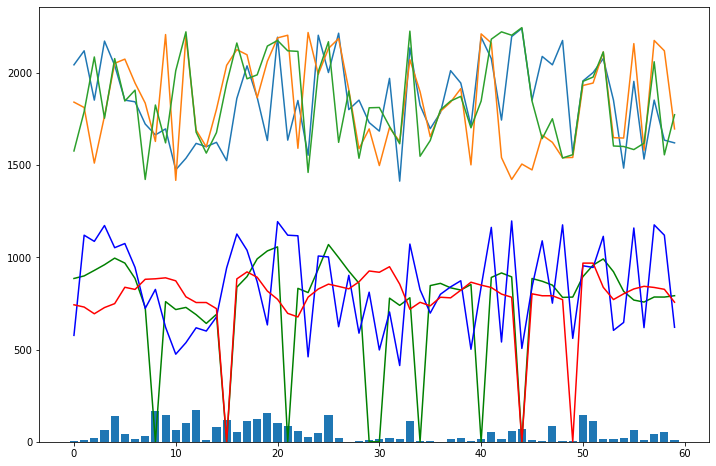

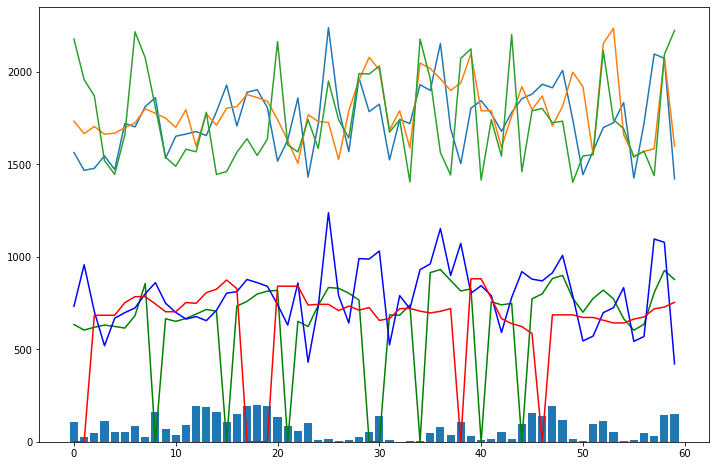

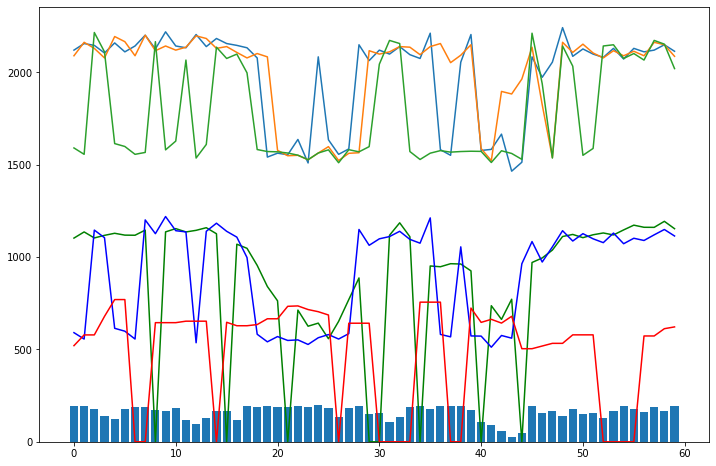

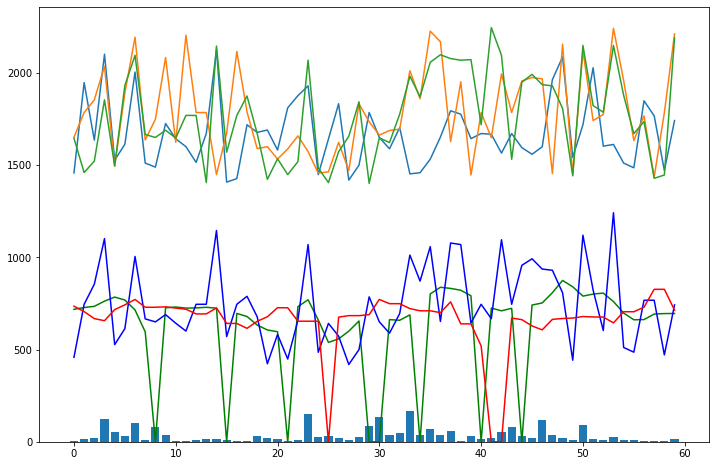

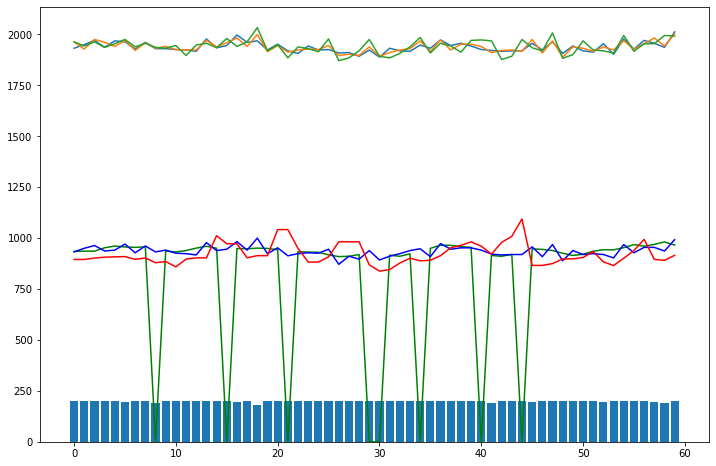

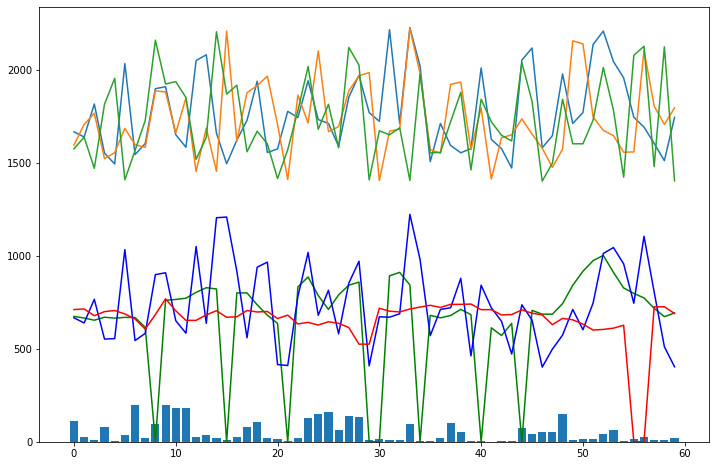

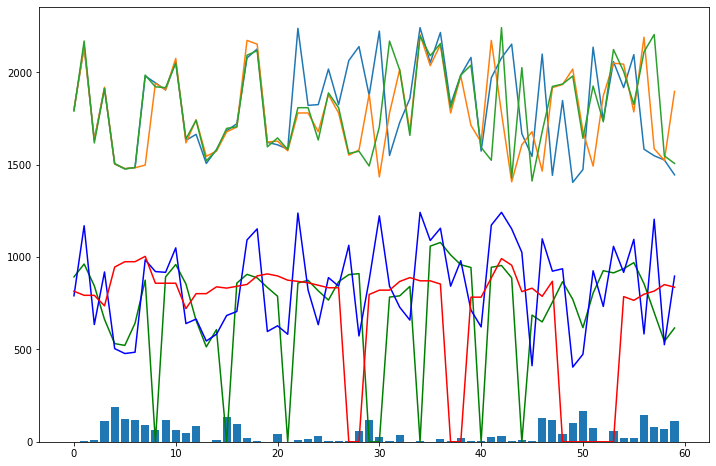

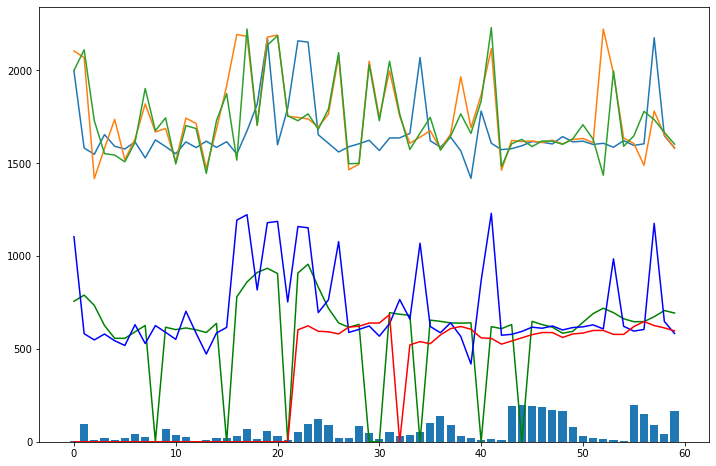

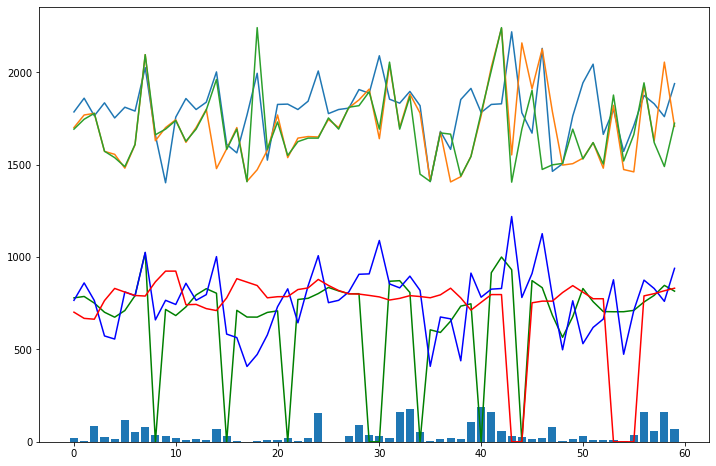

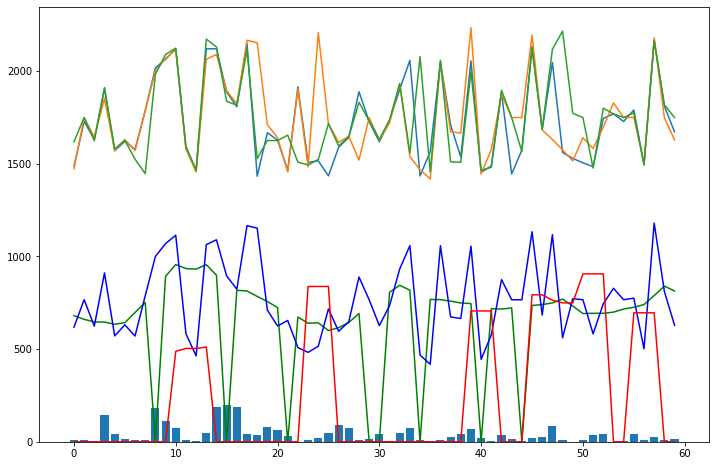

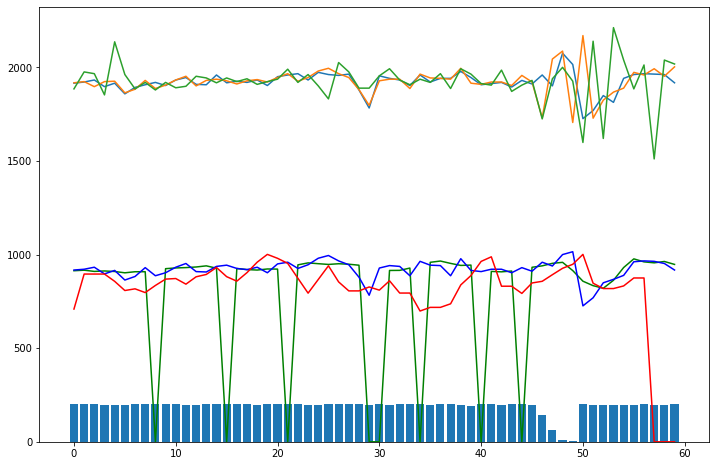

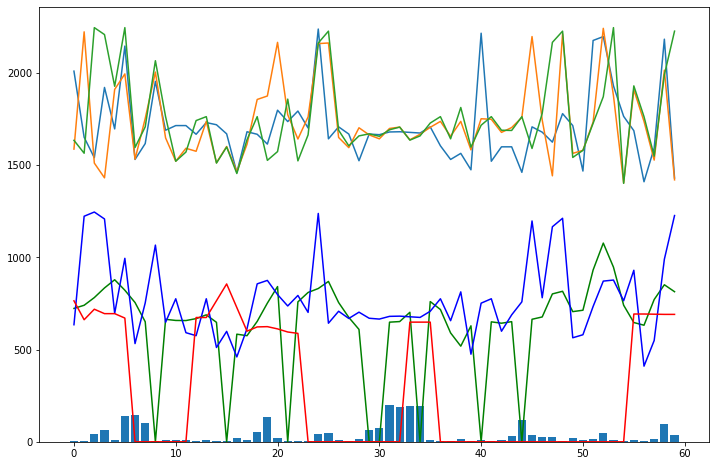

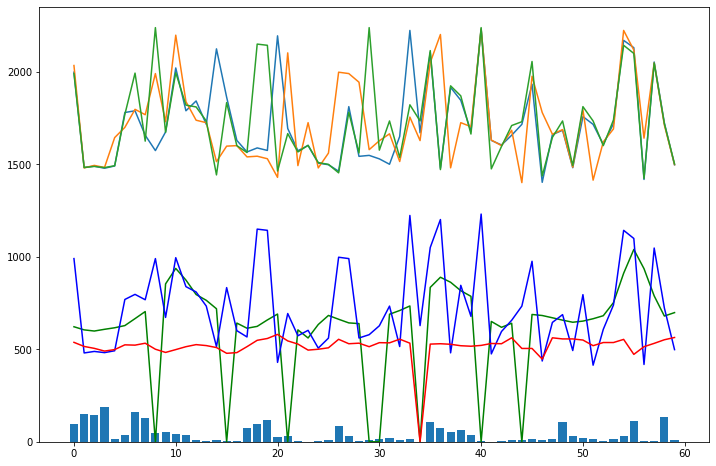

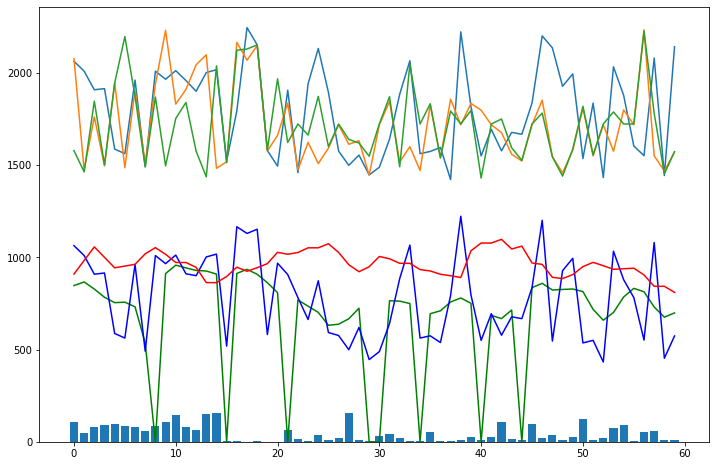

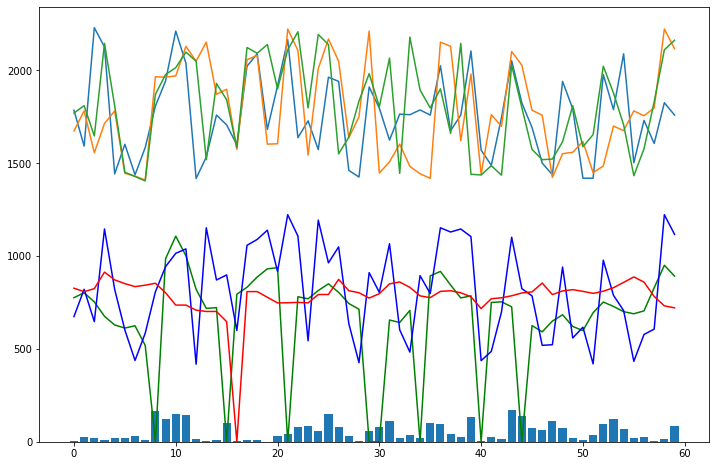

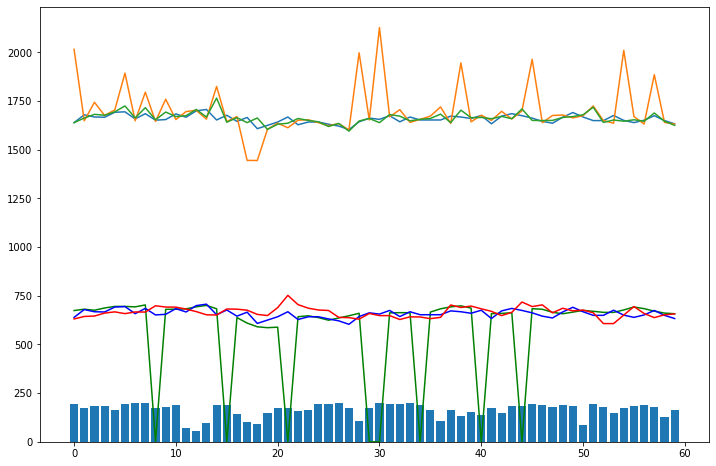

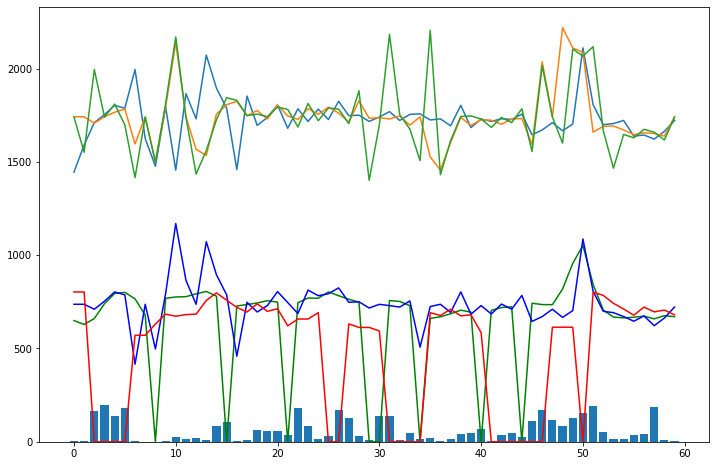

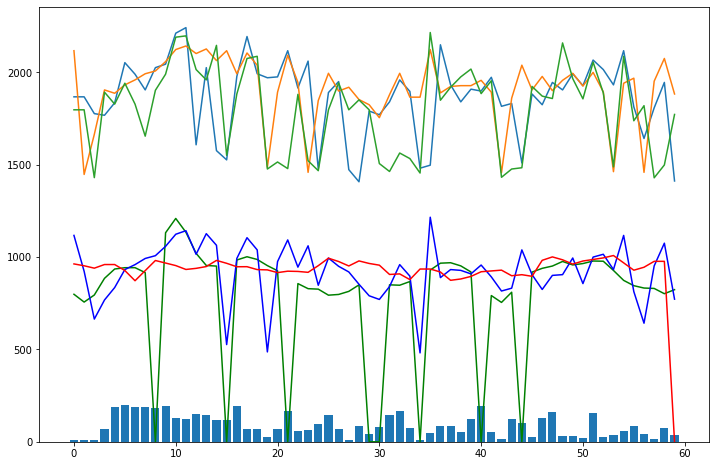

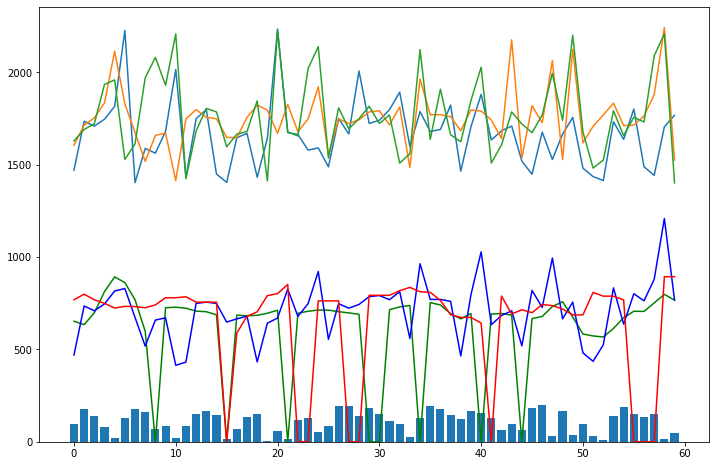

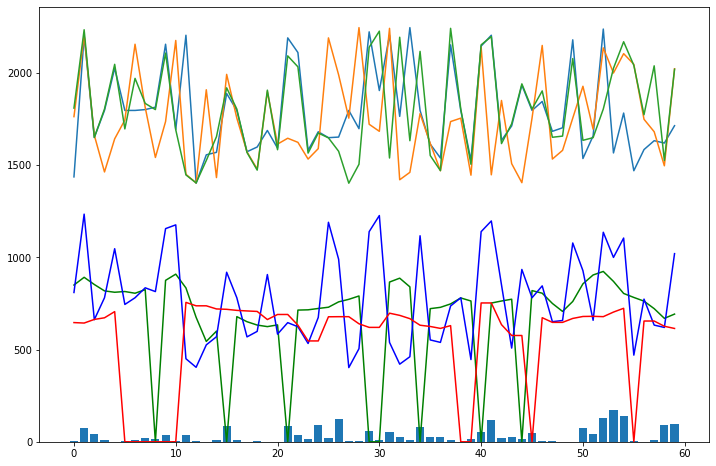

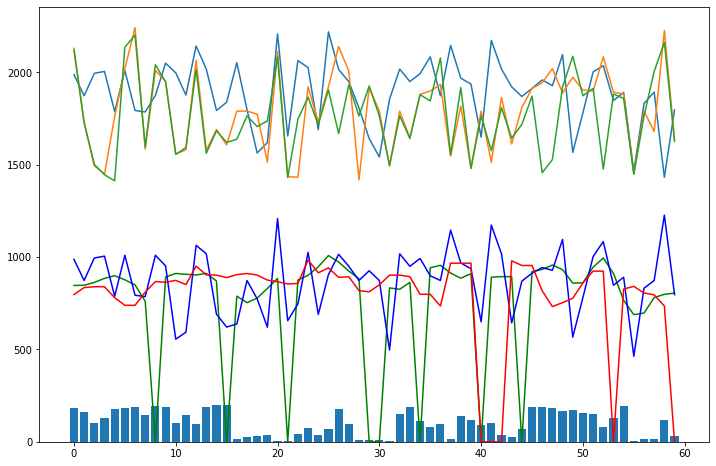

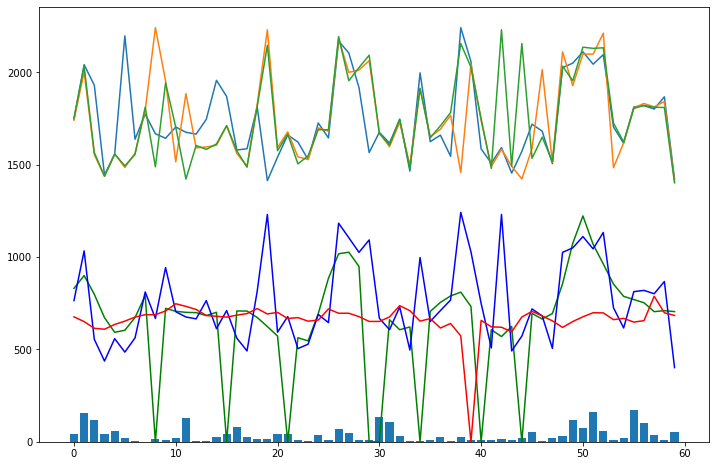

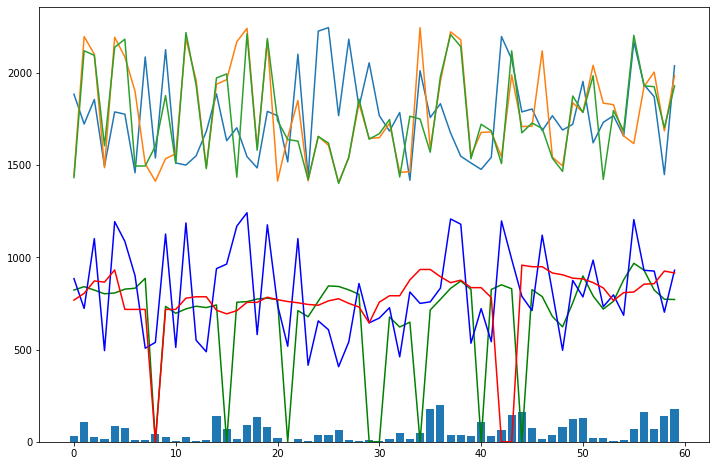

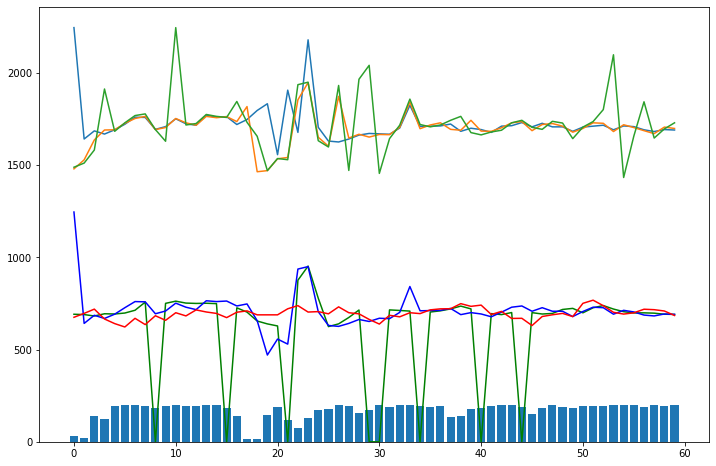

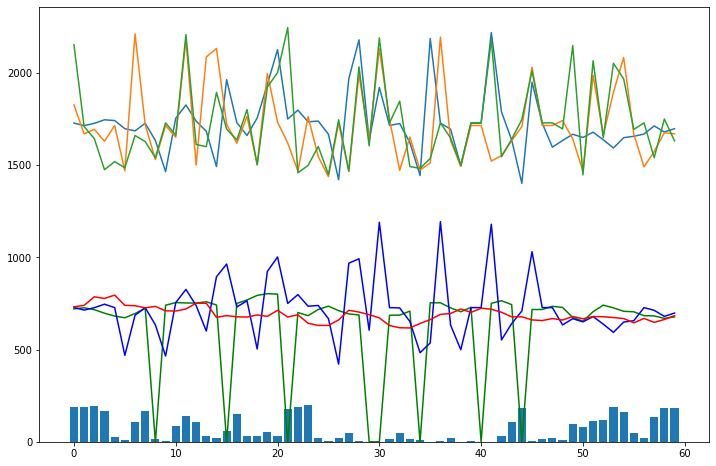

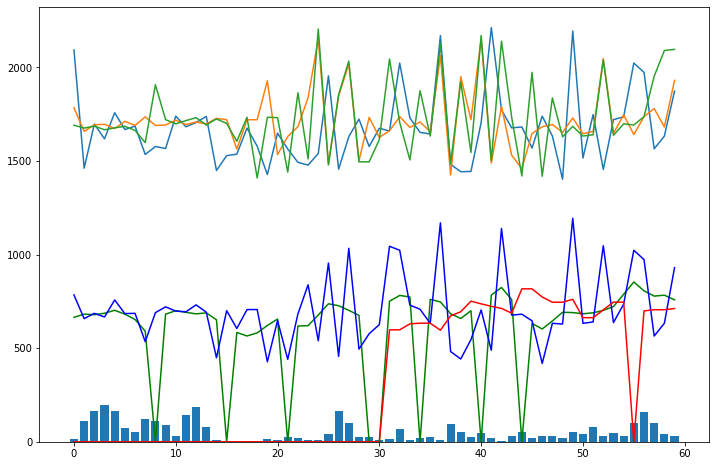

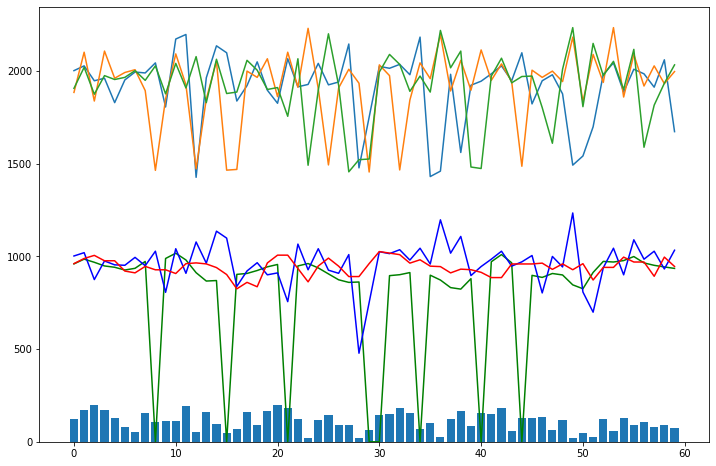

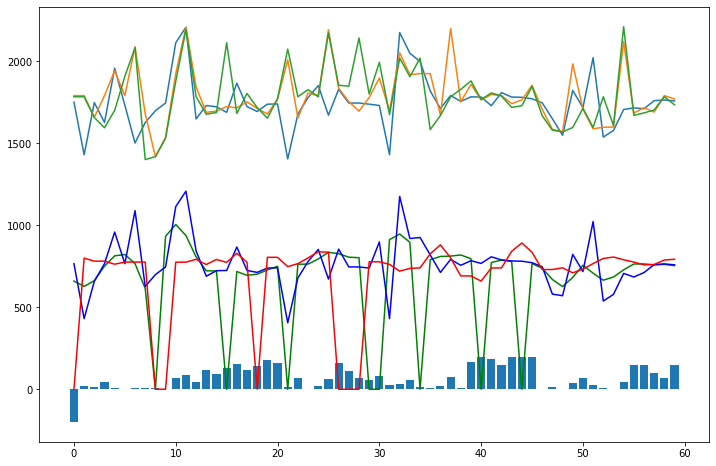

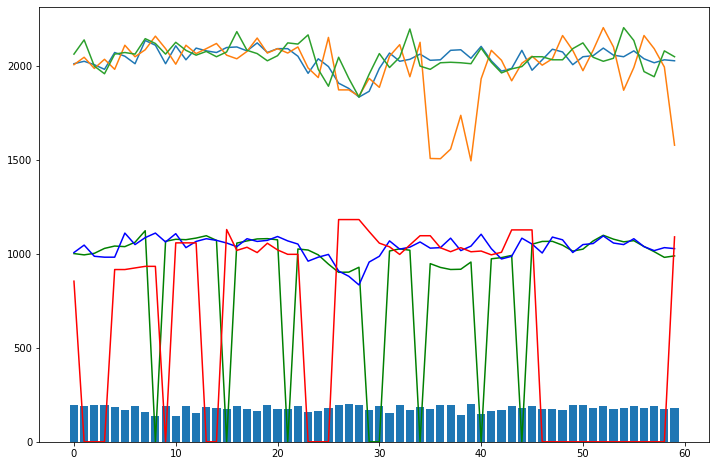

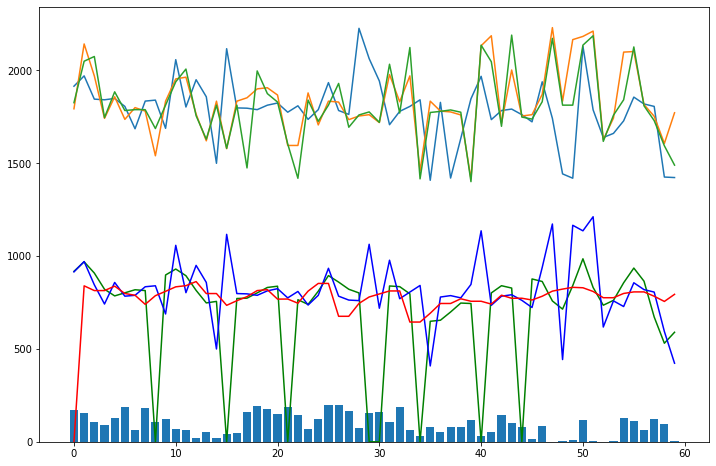

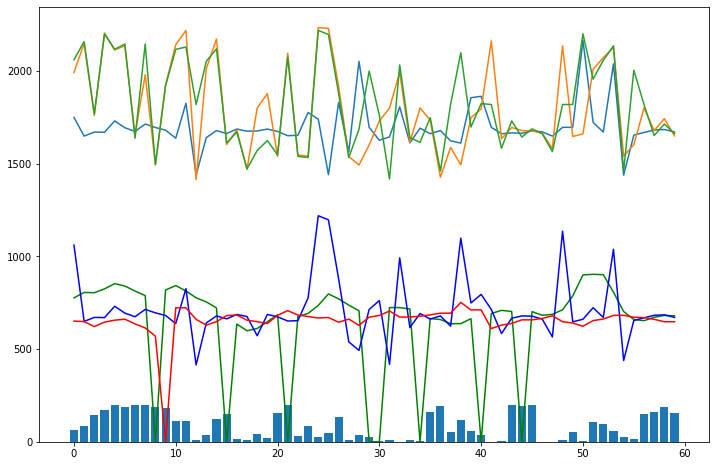

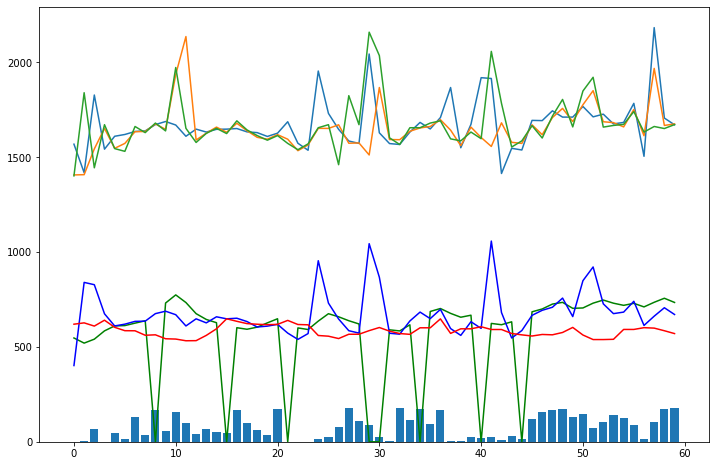

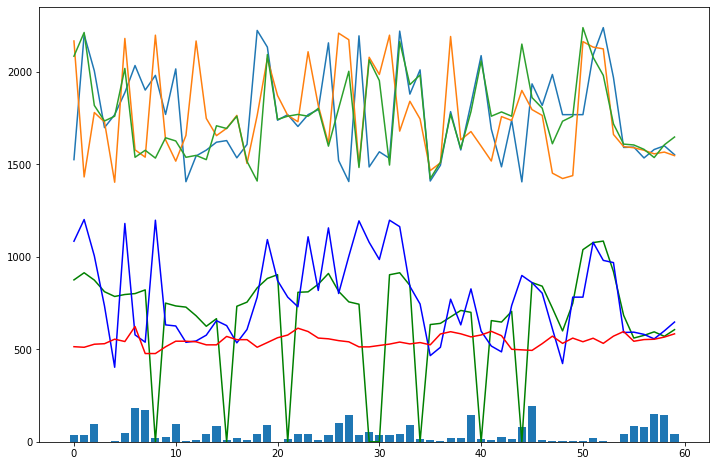

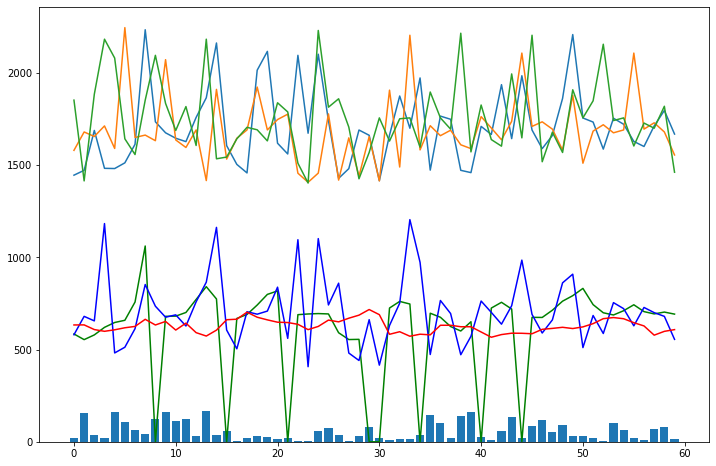

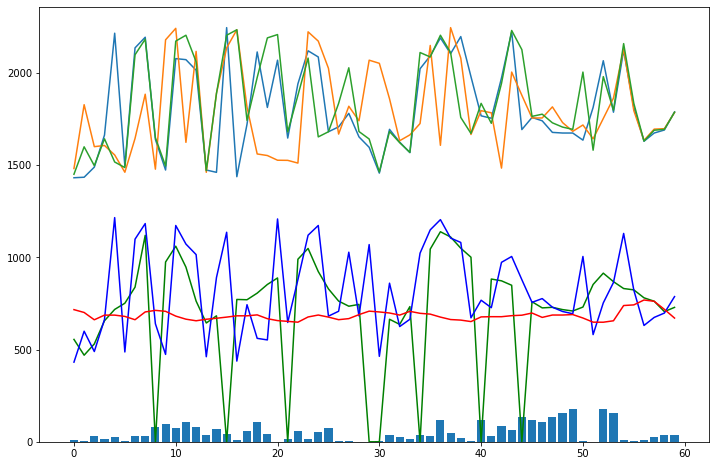

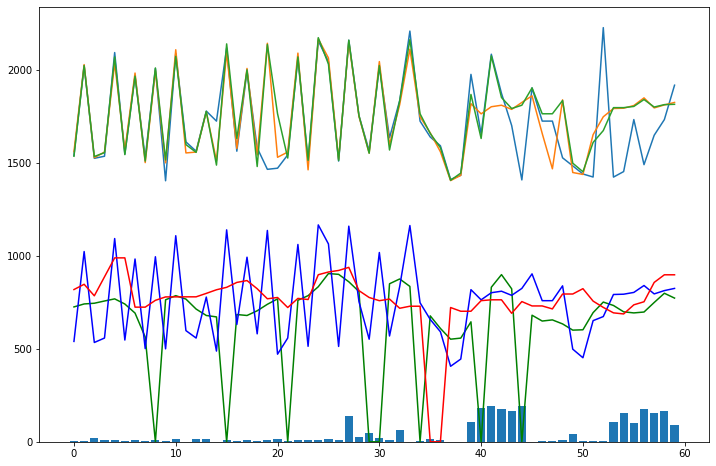

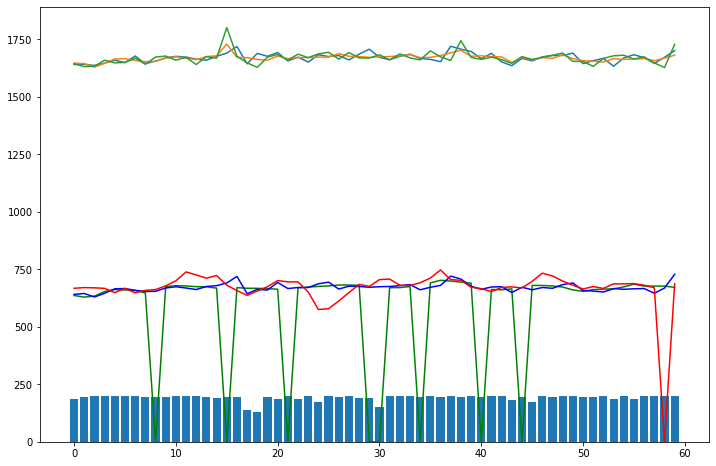

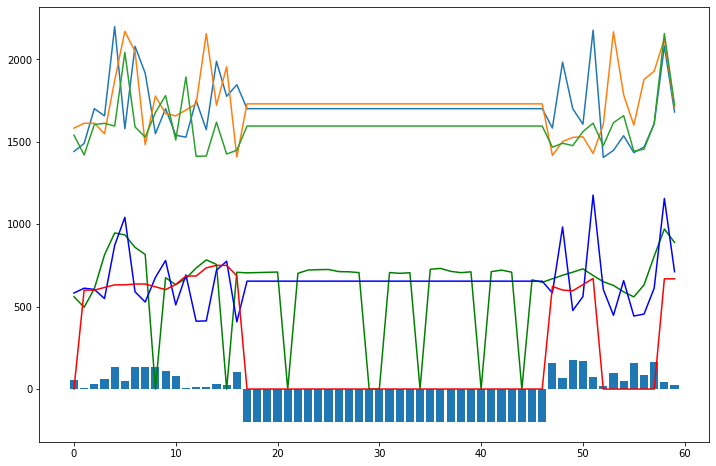

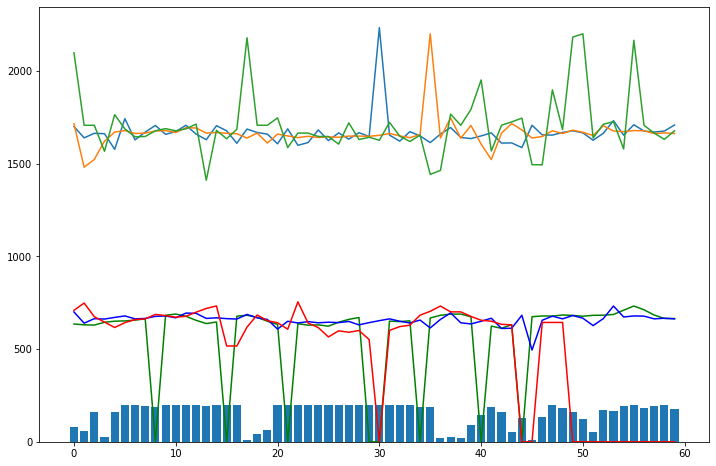

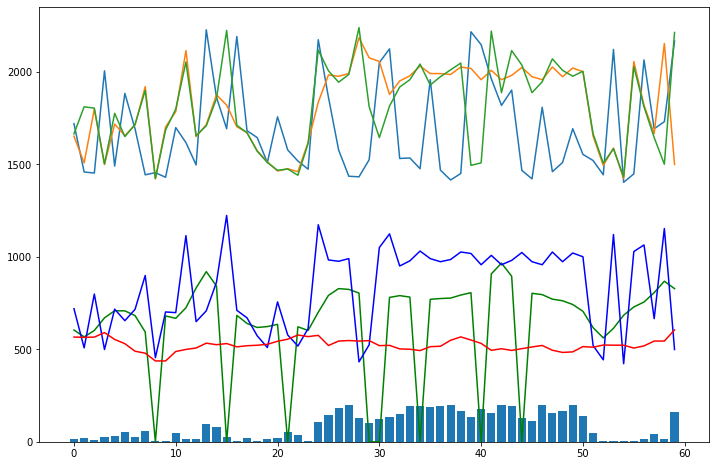

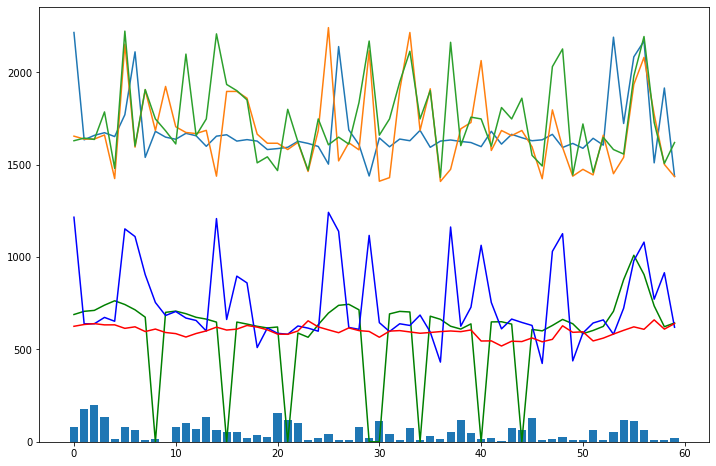

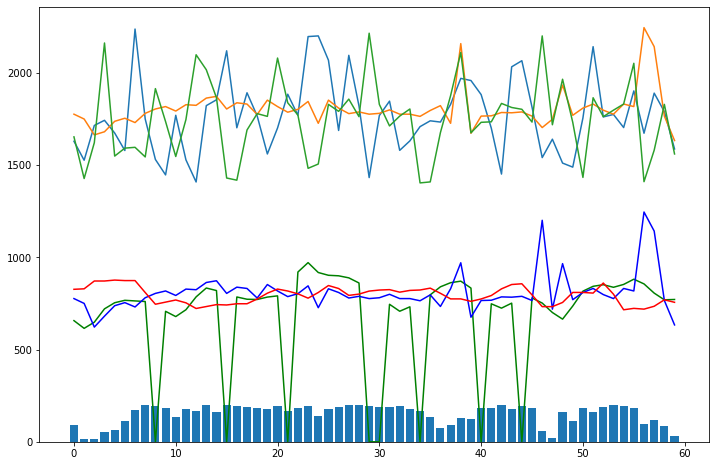

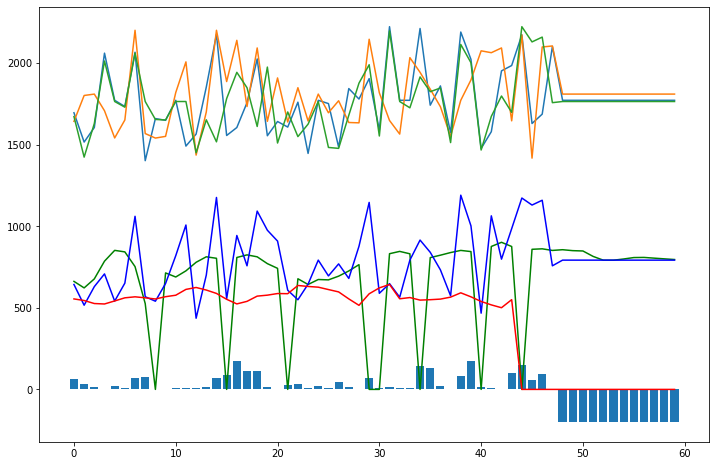

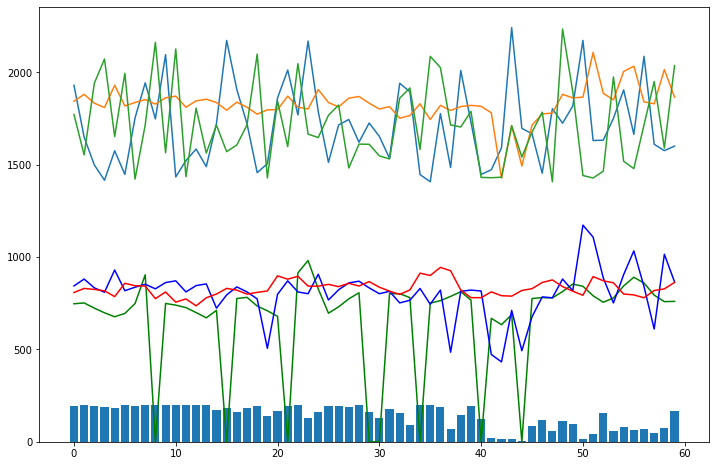

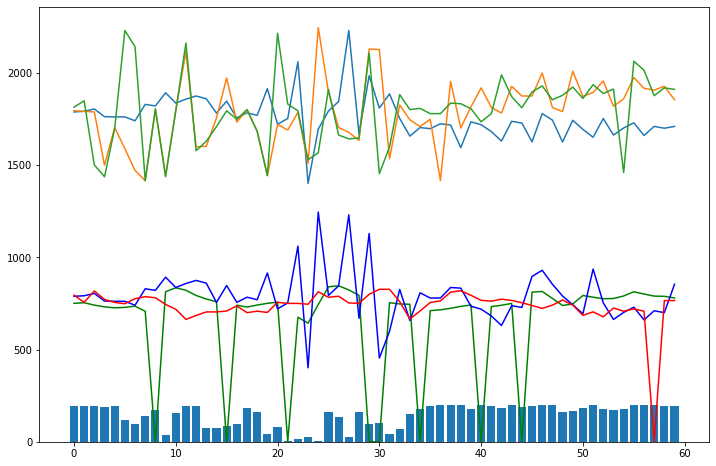

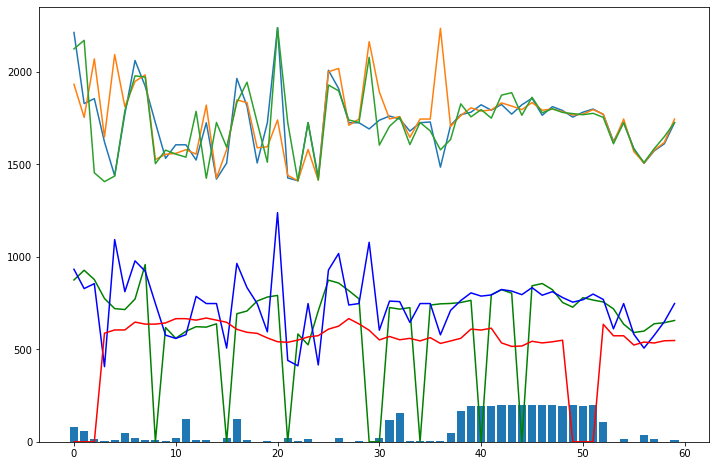

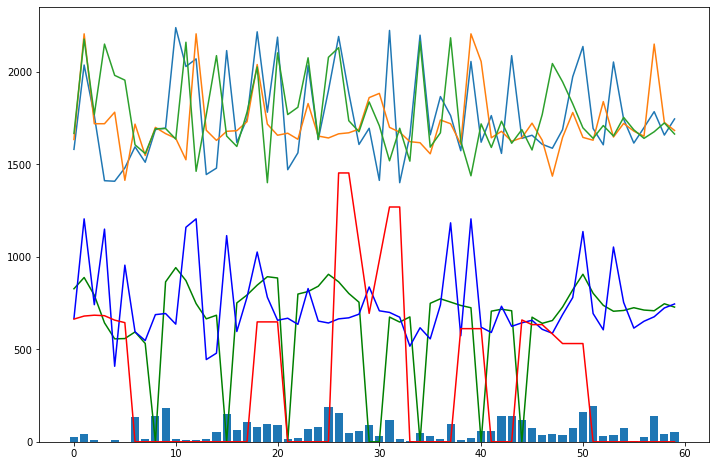

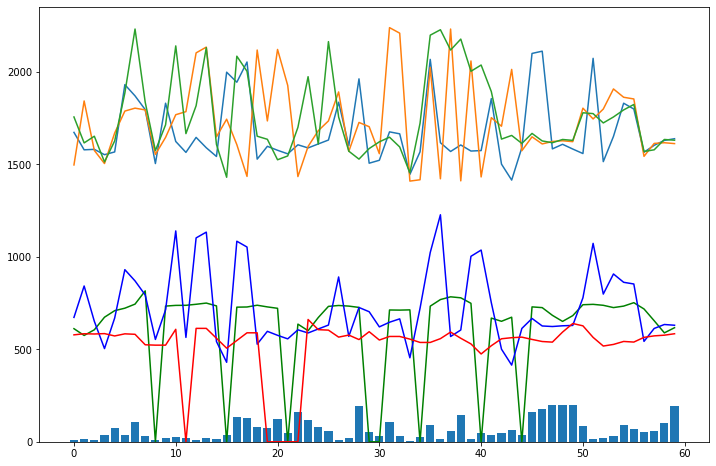

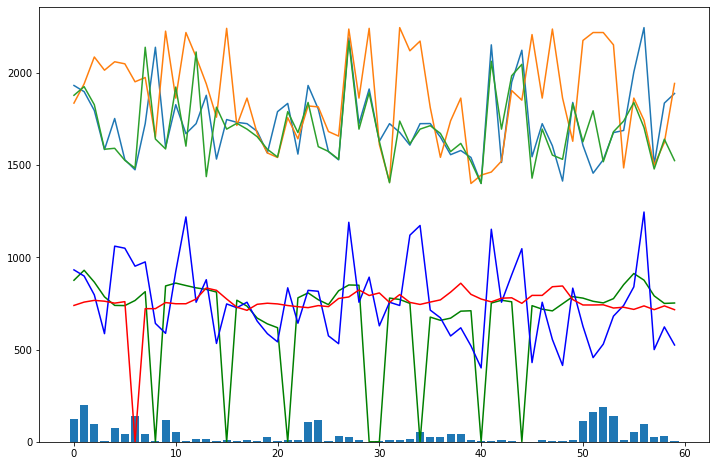

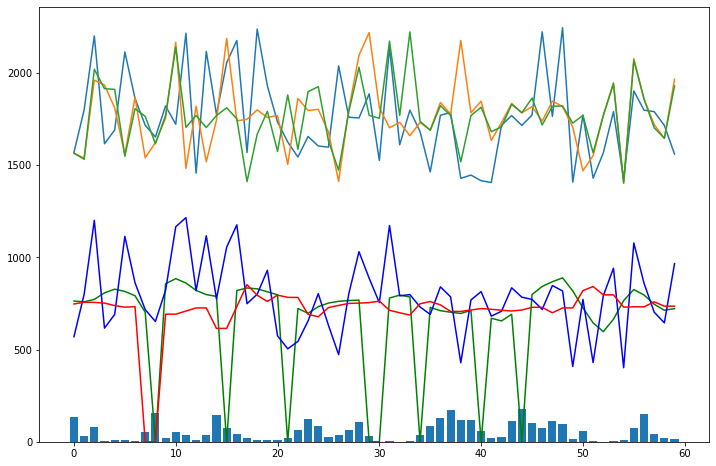

In [54]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:50]):
#     if np.sum(a)>0:
    plt.figure(figsize=(12,8))
    plt.plot(a,'g')
    plt.plot(X_test[i,:,:3]+1000)
    plt.plot(y_test[i],'b')
#     plt.bar(range(60),y_test[i]*400,.9)
#     plt.bar(range(60),quals_test[i]*400,.45)
    plt.plot(ecg_test[i],'r')
    plt.bar(range(60),quals_test[i]*200)
    plt.show()

In [55]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [56]:
X = X[X[:,0]>=0]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

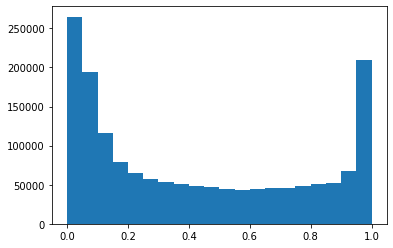

In [57]:
plt.figure()
plt.hist(X[:,0],20)
plt.show()
# y_test = y_test[:,:,0]
# X[:,0] = X[:,0]

(264913, 4) 0.0
(194486, 4) 0.05
(116226, 4) 0.1
(79159, 4) 0.15000000000000002
(64459, 4) 0.2
(56929, 4) 0.25
(53303, 4) 0.30000000000000004
(50311, 4) 0.35000000000000003
(48595, 4) 0.4
(46479, 4) 0.45
(44441, 4) 0.5
(43327, 4) 0.55
(44892, 4) 0.6000000000000001
(45799, 4) 0.65
(46095, 4) 0.7000000000000001
(47955, 4) 0.75
(50976, 4) 0.8
(53625, 4) 0.8500000000000001
(68180, 4) 0.9
(145290, 4) 0.9500000000000001
20 20


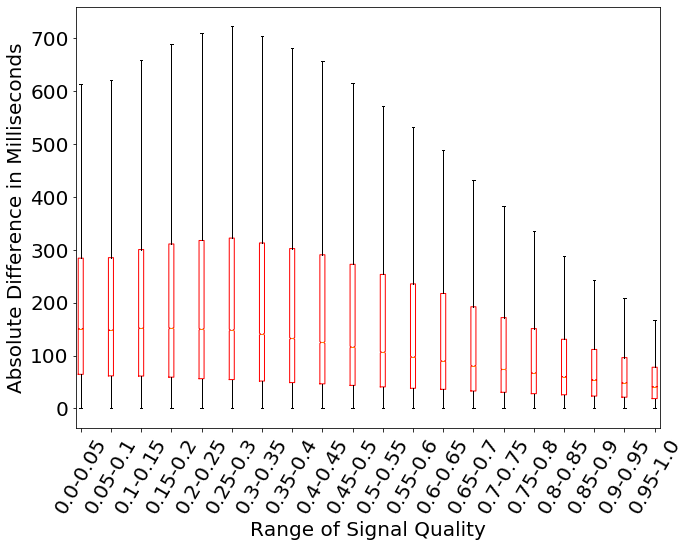

In [58]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
# b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
# for box in b['boxes']:
#     box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

(264913, 4) 0.0
(194486, 4) 0.05
(116226, 4) 0.1
(79159, 4) 0.15000000000000002
(64459, 4) 0.2
(56929, 4) 0.25
(53303, 4) 0.30000000000000004
(50311, 4) 0.35000000000000003
(48595, 4) 0.4
(46479, 4) 0.45
(44441, 4) 0.5
(43327, 4) 0.55
(44892, 4) 0.6000000000000001
(45799, 4) 0.65
(46095, 4) 0.7000000000000001
(47955, 4) 0.75
(50976, 4) 0.8
(53625, 4) 0.8500000000000001
(68180, 4) 0.9
(145290, 4) 0.9500000000000001
20 20


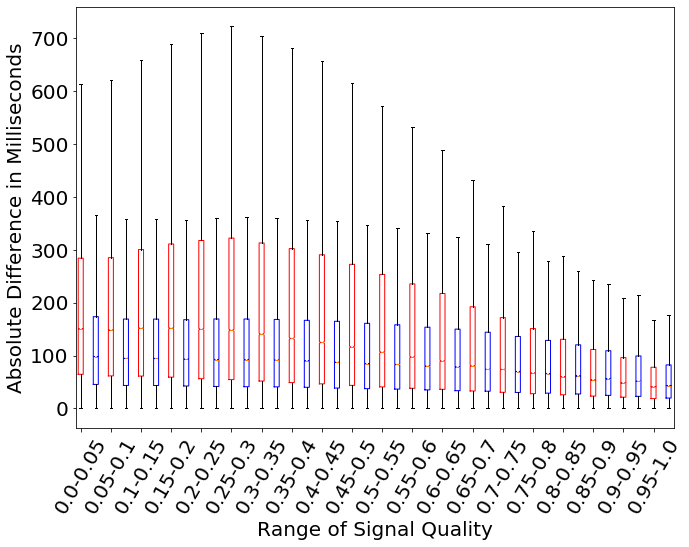

In [59]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [60]:
from hrvanalysis import get_time_domain_features,get_frequency_domain_features
w = []
x = []
y = []
z = []

q = []
s = 'range_nni'
def get_weighted_avg(test):
    for i in range(2,test.shape[0]-3):
        test[i,1] = np.sum([test[k,1]*test[k,0] for k in range(i-2,i+3)])/np.sum(test[i-2:i+3,0].reshape(-1))
#         print(test[i,1])
    return test

for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    y_test_min = y_test[i].reshape(-1)
    index = np.where(qual_min>=0)[0]
    test = np.zeros((len(index),2))
#     print(len(qual_min),len(y_test_min))
    test[:,0] = qual_min[index]
    test[:,1] = y_test_min[index]
    test = test[~np.isnan(test[:,1])]
    test = test[test[:,1]>0]
    test[:,0] = test[:,0]+.01
    y_test_min1 = get_weighted_avg(test)[:,1]
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    ecg_min= ecg_min[~np.isinf(ecg_min)]
    
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_pred_min = y_pred_min[y_pred_min>0]
    y_pred_min = y_pred_min[~np.isinf(y_pred_min)]
    
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[index] 
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    y_test_min = y_test_min[~np.isinf(y_test_min)]
    
#     y_test_min = test[:,0]
    if len(ecg_min)<40 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    w.append(np.array(list(get_time_domain_features(y_test_min1).values())))
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
#     x.append(np.array(list(get_frequency_domain_features(y_pred_min).values())))
#     y.append(np.array(list(get_frequency_domain_features(ecg_min).values())))
#     z.append(np.array(list(get_frequency_domain_features(y_test_min).values())))
    q.append(len(np.where(qual_min>.5)[0])/60)

In [61]:
preds,ecgs,fpreds,q,fpredsavg = np.array(x),np.array(y),np.array(z),np.array(q),np.array(w)

In [62]:
preds.shape,ecgs.shape,fpreds.shape,q.shape,fpredsavg.shape

((31022, 16), (31022, 16), (31022, 16), (31022,), (31022, 16))

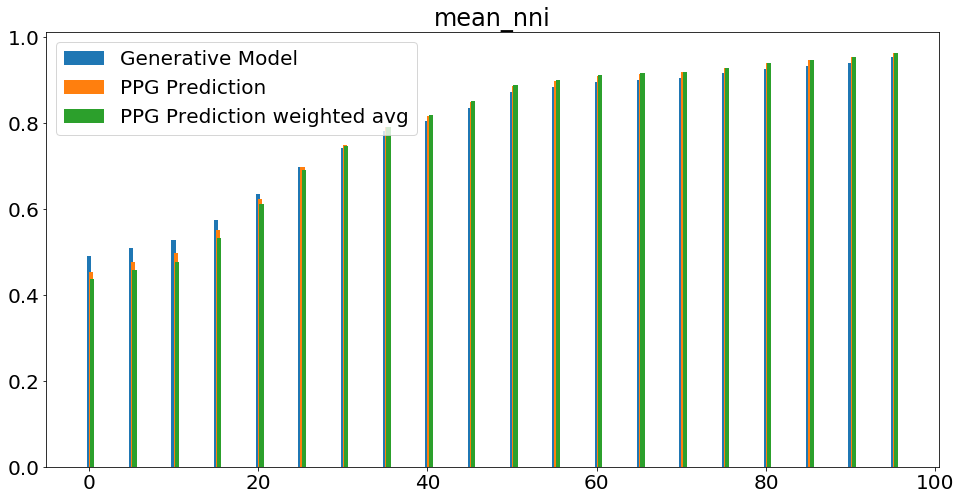

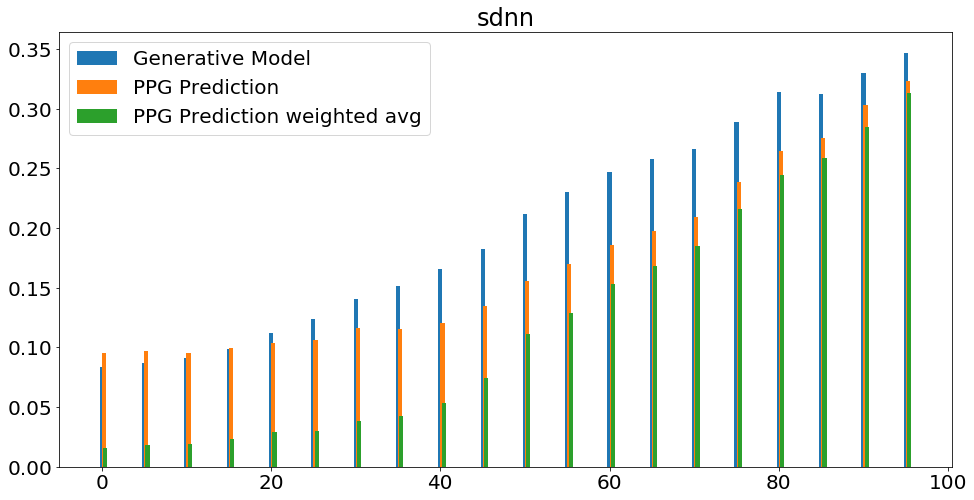

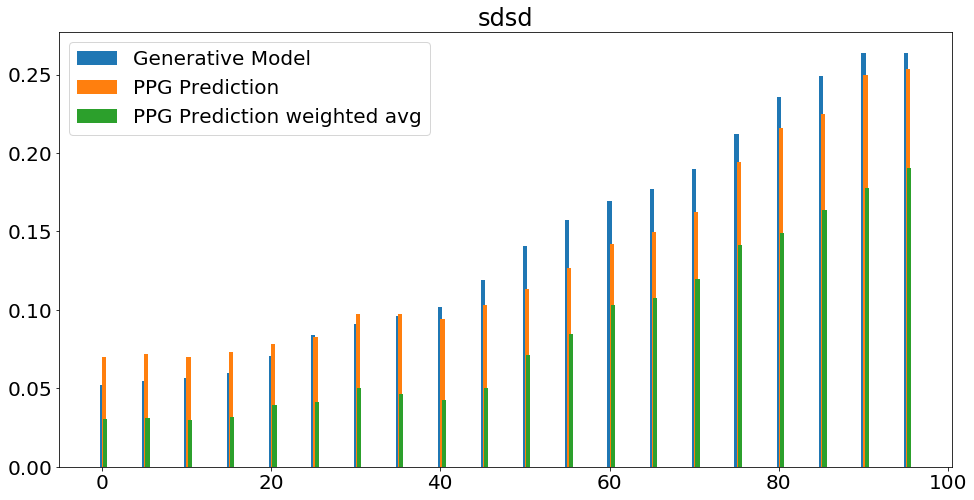

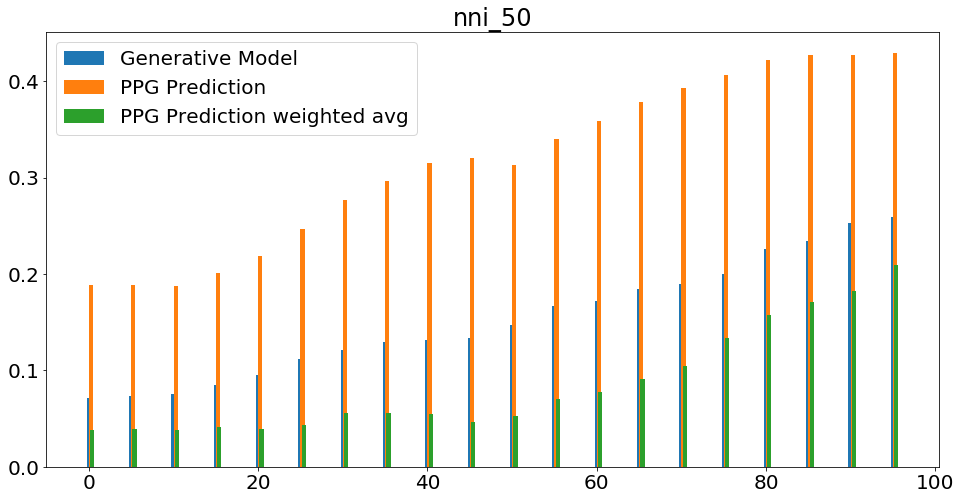

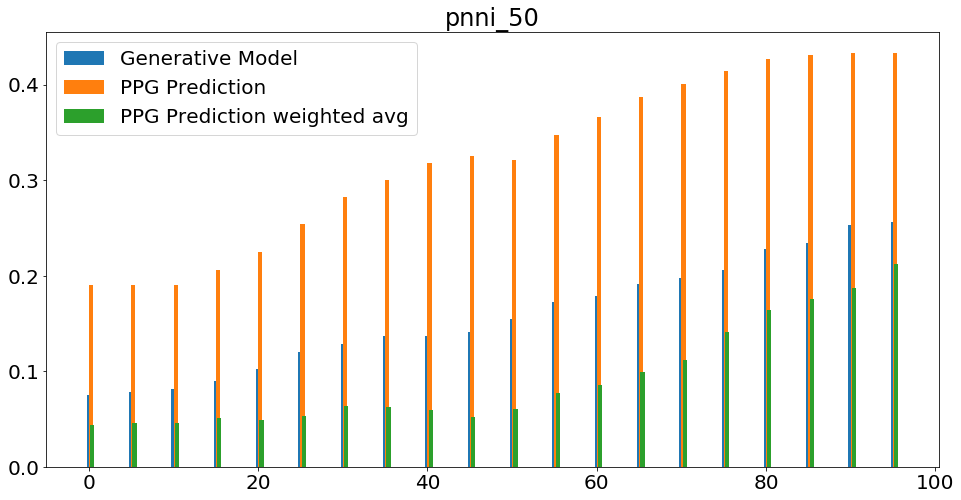

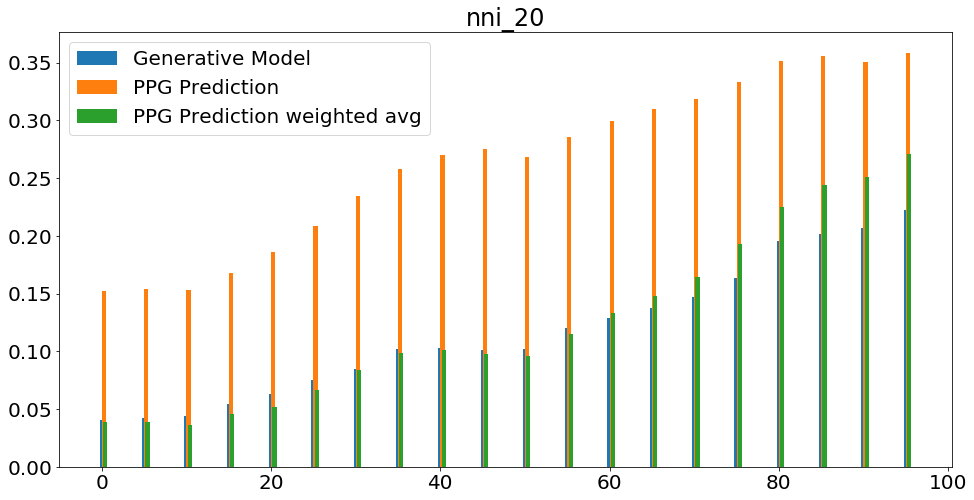

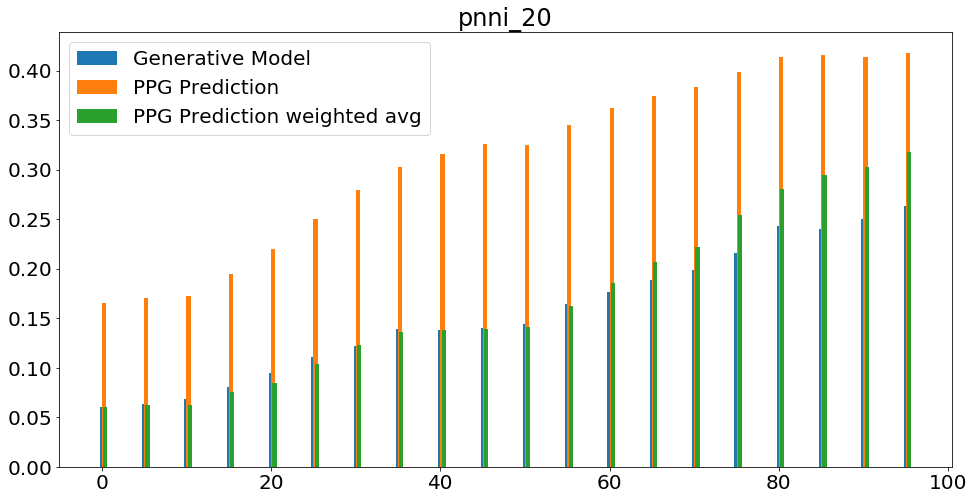

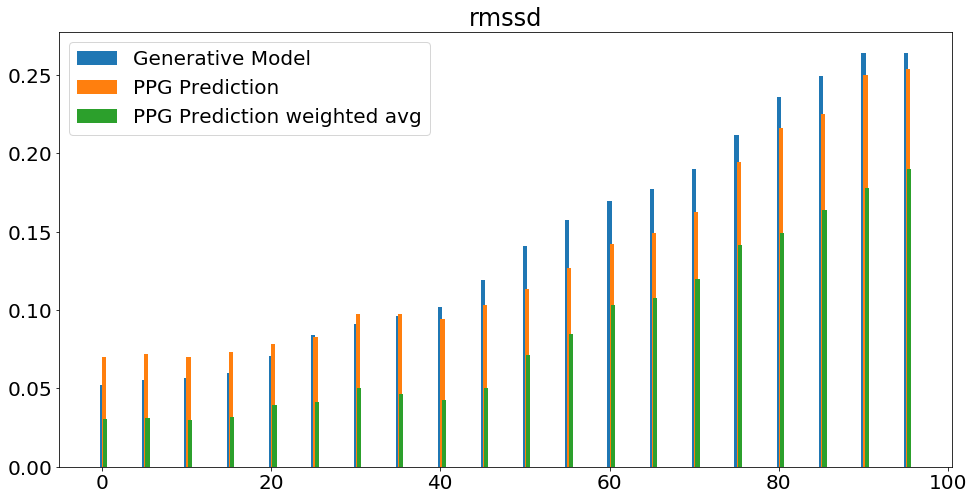

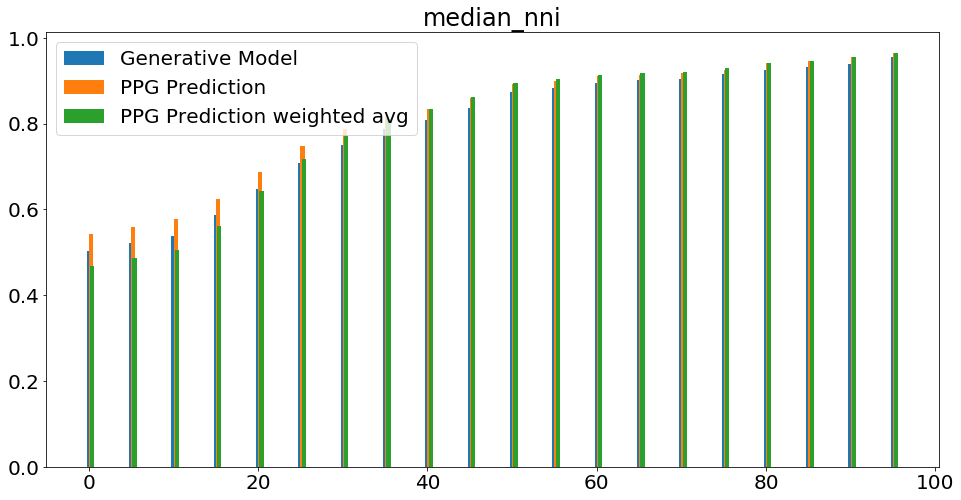

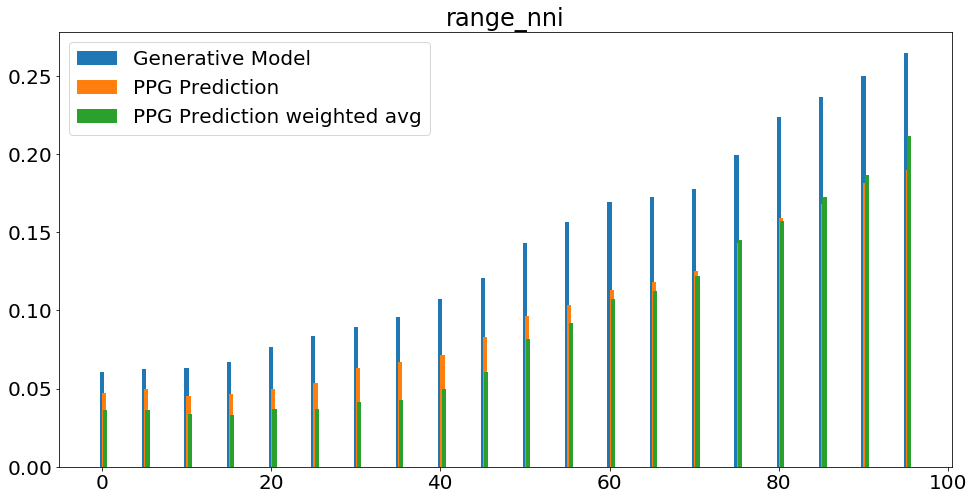

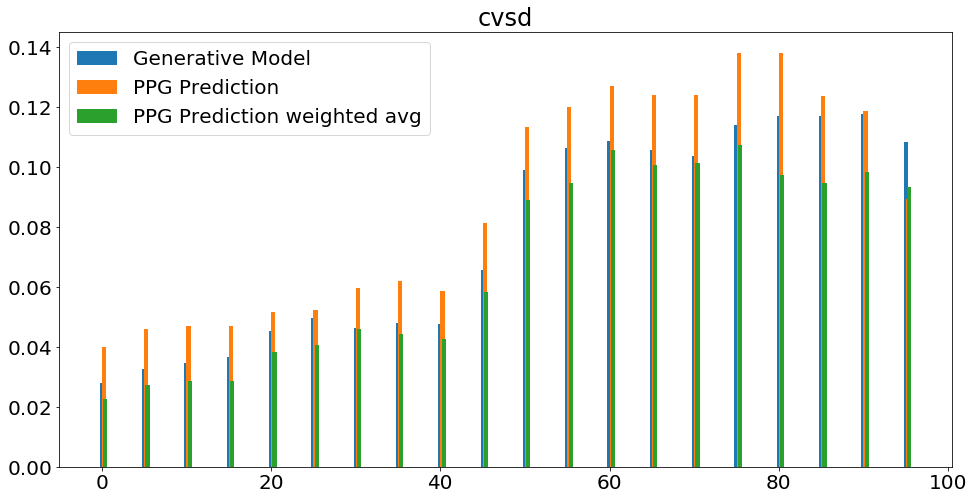

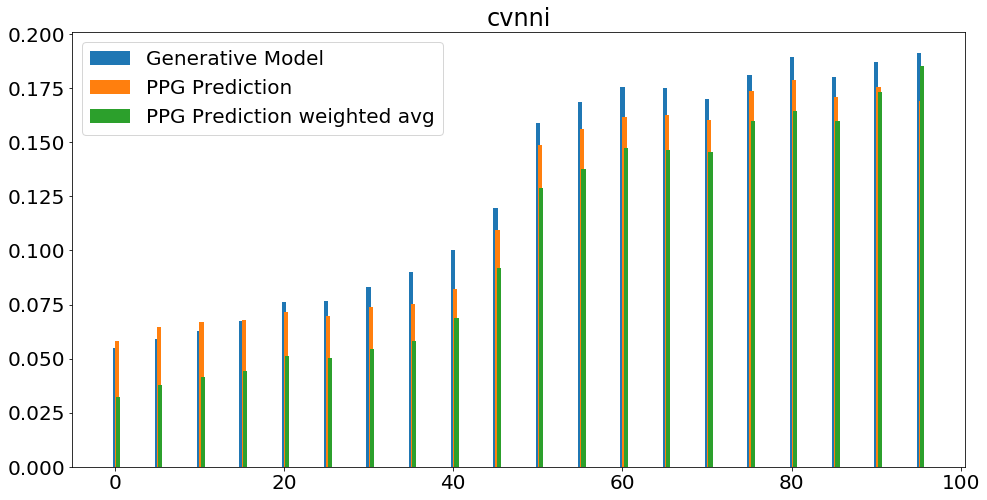

In [63]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    y2 = []
    for i in np.linspace(0,.95,20):
        index = np.where((q>=i)&(q<=i+.5))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(np.round(100*i))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
            y2.append(get_pearson(ecgs[index,j],fpredsavg[index,j]))
        except:
            continue
    x = np.array(x)
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x+.25,y1,.5,label='PPG Prediction')
        plt.bar(x+.4,y2,.5,label='PPG Prediction weighted avg')
        plt.title(feature_col[j])
#         plt.ylim([0,1])
        plt.legend()
#         plt.xticks(rotation=60)
        plt.show()
    except Exception as e:
        continue

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability